In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import pandas as pd
import seaborn as sns

from tensorflow.keras import losses, regularizers, Model, Input, layers

from itertools import product

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                  untar=True, cache_dir='../../../../Downloads',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb_v1/aclImdb')
train_dir = os.path.join(dataset_dir, 'train')

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [3]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [4]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
SEED = 42

train_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(dataset_dir, 'train'),
    batch_size=None,
    validation_split=0.2,
    subset='training',
    seed=SEED
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [6]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'This film was terrible. I have given it the high score of 2 as I have seen worse, but very few.<br /><br />From the clich\xc3\xa9d start of having the end of the film at the start and going back to the start at the end this film used everything in the box of tricks used in film making just for the sake of it, like a kid with too many toys. There was the endless, boring repetitive narration, slow motion, freeze frame, flashbacks and merged images etc - none of which made a dull film any better.<br /><br />It is called "16 years of alcohol", but there was little drinking or drunkeness and no depiction of withdrawal with the film jumping about all over the place with no coherent sense. The story was badly written and extremely pretentious and the direction was equally poor and it is a shame that people have put up further money for more films by Mr Jobson, previously know for being in a rubbish group and on TV making as much sense as this film does.<br /><br />I found it a major 

In [7]:
val_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(dataset_dir, 'train'),
    batch_size=None,
    validation_split=0.2,
    subset='validation',
    seed=SEED
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [8]:
test_ds = tf.keras.utils.text_dataset_from_directory(
    os.path.join(dataset_dir, 'test'),
    batch_size=None
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Found 25000 files belonging to 2 classes.


In [9]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(
      stripped_html,
      '[%s]' % re.escape(string.punctuation),
      ''
    )

In [10]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
  )

In [11]:
train_text = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [12]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [13]:
text_batch, label_batch = next(iter(train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", first_label)
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b"The Tattooed Stranger was another of those rare B-movies that BBC2 screened over Christmas/New Year 2005-2006. See also They Live By Night and The Brighton Strangler.<br /><br />In this one, a man walking his dog in Central Park comes across an abandoned car and discovers a dead woman inside. She was shot and police then try to identify her with only a tattoo as the main clue. After being identified, the murderer is discovered and is shot in the shootout at the end.<br /><br />Most of this movie was shot on location in and around New York, so we get to see some areas of the city we don't normally see, especially the back streets.<br /><br />Mostly unknowns are in the cast, with John Miles getting top billing.<br /><br />The Tattooed Stranger is worth seeking out. Excellent but rather obscure.<br /><br />Rating: 3 stars out of 5.", shape=(), dtype=string)
Label tf.Tensor(1, shape=(), dtype=int32)
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array

In [14]:
embedding_dim = 64
epochs = 10

def build_and_train(
    architecture=tf.keras.layers.SimpleRNN,
    hidden_layers=[64, 32],
    dropout=0.5,
    l2=0.01,
    verbose=0
):
    """
    Builds a text‐classification model (embedding → RNNs → dense) using the Functional API,
    compiles it with BinaryCrossentropy+metrics [BinaryAccuracy, AUC], trains on train_ds/val_ds,
    and returns:
       - model: the final Model
       - history: the History object from model.fit
       - activations_model: a Model(inputs=..., outputs=[...]) that returns intermediate activations
                             (one output per RNN layer + final Dense)
    """
    # 1. Input layer (assuming vectorize_layer has been defined earlier as TextVectorization)
    inputs = tf.keras.Input(shape=(1,), dtype=tf.string, name="input_tokens")
    x = tf.keras.layers.Lambda(lambda x: tf.squeeze(x, axis=1))(inputs)
    x = vectorize_layer(x)  # apply text vectorization (vocabulary → integer IDs)

    # 2. Embedding (with mask_zero=True)
    x = tf.keras.layers.Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=embedding_dim,
        mask_zero=True,
        name="embedding"
    )(x)

    # 3. Stack of RNN layers (SimpleRNN / LSTM / GRU). Capture each layer’s output.
    intermediate_outputs = []
    prev = x
    reg = regularizers.L2(l2=l2)

    for i, h in enumerate(hidden_layers):
        # if this is not the last RNN layer, we set return_sequences=True so that next RNN can take full sequence
        return_seq = (i < len(hidden_layers) - 1)
        rnn_layer = architecture(
            units=h,
            kernel_regularizer=reg,
            return_sequences=return_seq,
            name=f"{architecture.__name__}_{h}"
        )
        out = rnn_layer(prev)
        intermediate_outputs.append(out)  # collect for activations
        prev = out

    # 4. A final Dense “pooling” layer (you already had a Dense(64, relu) before classification)
    x_dense = tf.keras.layers.Dense(64, activation='relu', name="dense_pool")(prev)
    intermediate_outputs.append(x_dense)

    # 5. Dropout (if requested)
    if dropout > 0.0:
        x_dense = tf.keras.layers.Dropout(dropout, name="dropout")(x_dense)

    # 6. Final classification‐logit (Dense(1)) – no activation here, since we'll use from_logits=True
    logits = tf.keras.layers.Dense(1, name="classifier")(x_dense)
    intermediate_outputs.append(logits)

    # 7. Build the model
    model = Model(inputs=inputs, outputs=logits, name=f"{architecture.__name__}_text_classifier")

    # 8. Compile
    model.compile(
        loss=losses.BinaryCrossentropy(from_logits=True),
        optimizer='adam',
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )

    # 9. Callbacks
    checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_binary_accuracy',
        mode='max',
        save_best_only=True
    )

    # 10. Fit
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stopping, model_checkpoint_callback],
        verbose=verbose
    )
    # 11. Load best weights
    model.load_weights(checkpoint_filepath)

    # 12. Build an “activations_model” that, given the same inputs, will output all intermediate activations
    activations_model = Model(inputs=inputs, outputs=intermediate_outputs, name="activations_model")

    return model, history, activations_model


In [15]:
def plot_history(history):
  history_dict = history.history

  acc = history_dict['binary_accuracy']
  val_acc = history_dict['val_binary_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']
  auc = history_dict['auc']
  val_auc = history_dict['val_auc']

  epochs = range(1, len(acc) + 1)

  fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))

  plt.subplot(1, 3, 1)
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 3, 2)
  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')

  plt.subplot(1, 3, 3)
  plt.plot(epochs, auc, 'r', label='Training AUC-ROC')
  plt.plot(epochs, val_auc, 'b', label='Validation AUC-ROC')
  plt.title('Training and validation AUC-ROC')
  plt.xlabel('Epochs')
  plt.ylabel('AUC-ROC')
  plt.legend(loc='lower right')

  plt.show()

In [16]:
def visulize_activations(architecture, activations):
  for batch_input, batch_labels in val_ds.take(1):
      sample_input = batch_input
      sample_labels = batch_labels
      break

  layer_activations = activations(sample_input, training=False)

  for i, act in enumerate(layer_activations):
      print(f"Layer {i} output shape: {act.shape}")

  first_rnn_act = layer_activations[0].numpy()

  if first_rnn_act.ndim == 2:
        print(f"⚠️ Skipping visualization: output is 2D (no sequence returned).")
  elif first_rnn_act.ndim !=3:
        print(f"⚠️ Unexpected activation shape: {first_rnn_act.shape}")
  else:
    plt.figure(figsize=(8,4))
    plt.imshow(first_rnn_act[0, :50, :].T, aspect='auto')
    plt.title(f"{architecture} (first sample, first 50 time steps)")
    plt.xlabel("Time step")
    plt.ylabel("Hidden Unit index")
    plt.colorbar(label="Activation")
    plt.show()


In [17]:
precomputed_results = [
    ('SimpleRNN', (64, 16), 0.2, 0.01, 0.5000, 0.7383, 0.5000),
    ('SimpleRNN', (64, 16), 0.2, 0.001, 0.8031, 0.5286, 0.8104),
    ('SimpleRNN', (64, 16), 0.5, 0.01, 0.5000, 0.7313, 0.5029),
    ('SimpleRNN', (64, 16), 0.5, 0.001, 0.6742, 0.6750, 0.6988),
    ('SimpleRNN', (16, 64), 0.2, 0.01, 0.5000, 0.7868, 0.5127),
    ('SimpleRNN', (16, 64), 0.2, 0.001, 0.8261, 0.4483, 0.8471),
    ('SimpleRNN', (16, 64), 0.5, 0.01, 0.8302, 0.4795, 0.8425),
    ('SimpleRNN', (16, 64), 0.5, 0.001, 0.8183, 0.4553, 0.8399),
    ('SimpleRNN', (64,), 0.2, 0.01, 0.8305, 0.4516, 0.8457),
    ('SimpleRNN', (64,), 0.2, 0.001, 0.7810, 0.4936, 0.8140),
    ('SimpleRNN', (64,), 0.5, 0.01, 0.5000, 0.7008, 0.5000),
    ('SimpleRNN', (64,), 0.5, 0.001, 0.7893, 0.4829, 0.8175),

    # LSTM results
    ('LSTM', (64, 16), 0.2, 0.01, 0.8503, 0.4172, 0.8624),
    ('LSTM', (64, 16), 0.2, 0.001, 0.8505, 0.3897, 0.8692),
    ('LSTM', (64, 16), 0.5, 0.01, 0.8514, 0.3713, 0.8702),
    ('LSTM', (64, 16), 0.5, 0.001, 0.8498, 0.3942, 0.8660),
    ('LSTM', (16, 64), 0.2, 0.01, 0.8428, 0.4605, 0.8531),
    ('LSTM', (16, 64), 0.2, 0.001, 0.8530, 0.3493, 0.8831),
    ('LSTM', (16, 64), 0.5, 0.01, 0.8493, 0.4054, 0.8608),
    ('LSTM', (16, 64), 0.5, 0.001, 0.8554, 0.3587, 0.8778),
    ('LSTM', (64,), 0.2, 0.01, 0.8518, 0.3485, 0.8672),
    ('LSTM', (64,), 0.2, 0.001, 0.8607, 0.3448, 0.8829),
    ('LSTM', (64,), 0.5, 0.01, 0.8584, 0.3679, 0.8717),
    ('LSTM', (64,), 0.5, 0.001, 0.8594, 0.3364, 0.8791),

    # GRU results
    ('GRU', (64, 16), 0.2, 0.01, 0.8430, 0.4820, 0.8529),
    ('GRU', (64, 16), 0.2, 0.001, 0.8505, 0.4400, 0.8614),
    ('GRU', (64, 16), 0.5, 0.01, 0.8512, 0.3971, 0.8650),
    ('GRU', (64, 16), 0.5, 0.001, 0.8574, 0.3549, 0.8774),
    ('GRU', (16, 64), 0.2, 0.01, 0.8498, 0.3650, 0.8681),
    ('GRU', (16, 64), 0.2, 0.001, 0.8469, 0.4235, 0.8612),
    ('GRU', (16, 64), 0.5, 0.01, 0.8546, 0.3822, 0.8712),
    ('GRU', (16, 64), 0.5, 0.001, 0.8463, 0.3676, 0.8692),
    ('GRU', (64,), 0.2, 0.01, 0.8475, 0.3993, 0.8607),
    ('GRU', (64,), 0.2, 0.001, 0.8545, 0.3670, 0.8722),
    ('GRU', (64,), 0.5, 0.01, 0.8562, 0.3743, 0.8759),
    ('GRU', (64,), 0.5, 0.001, 0.8574, 0.3721, 0.8760),
]

⏭️ Skipping already computed: ('SimpleRNN', (64, 16), 0.2, 0.01)
⏭️ Skipping already computed: ('SimpleRNN', (64, 16), 0.2, 0.001)
⏭️ Skipping already computed: ('SimpleRNN', (64, 16), 0.5, 0.01)
⏭️ Skipping already computed: ('SimpleRNN', (64, 16), 0.5, 0.001)
⏭️ Skipping already computed: ('SimpleRNN', (16, 64), 0.2, 0.01)
⏭️ Skipping already computed: ('SimpleRNN', (16, 64), 0.2, 0.001)
⏭️ Skipping already computed: ('SimpleRNN', (16, 64), 0.5, 0.01)
⏭️ Skipping already computed: ('SimpleRNN', (16, 64), 0.5, 0.001)
⏭️ Skipping already computed: ('SimpleRNN', (64,), 0.2, 0.01)
⏭️ Skipping already computed: ('SimpleRNN', (64,), 0.2, 0.001)
⏭️ Skipping already computed: ('SimpleRNN', (64,), 0.5, 0.01)
⏭️ Skipping already computed: ('SimpleRNN', (64,), 0.5, 0.001)
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 144s 437ms/step - auc: 0.5922 - binary_accuracy: 0.5641 - loss: 1.2957 - val_auc: 0.8530 - val_binary_accuracy: 0.8262 - val_loss: 0.4115
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 133s 424

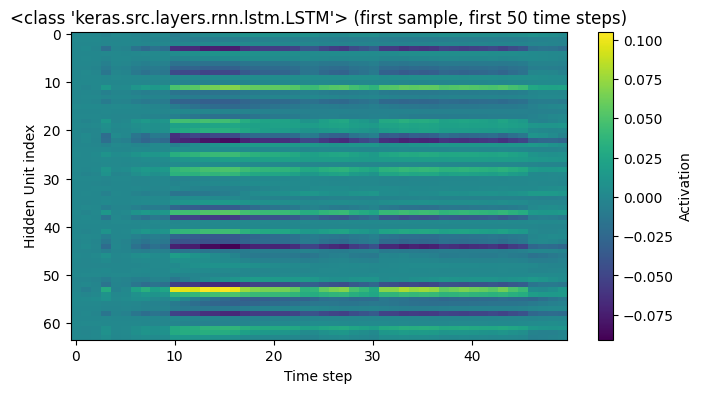

Architecture: <class 'keras.src.layers.rnn.lstm.LSTM'>, Hidden layers: [64, 16], Dropout: 0.2, L2: 0.01, Acc: 0.8503, Loss: 0.4172, AUC: 0.8624


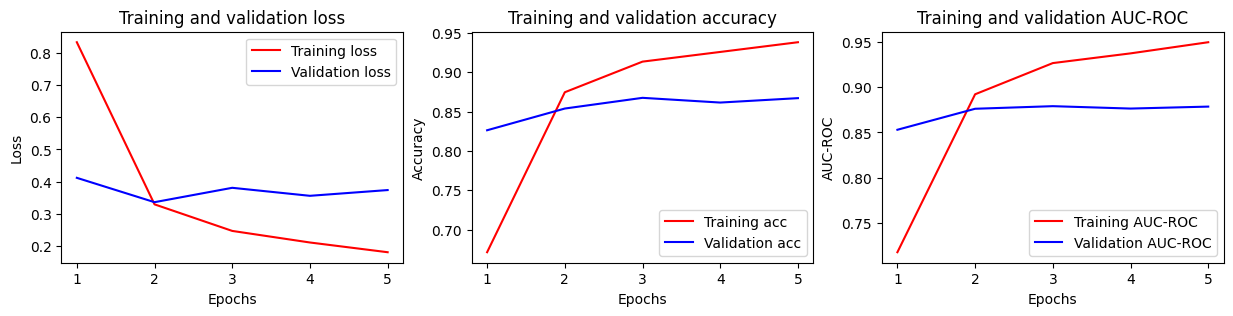

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 149s 451ms/step - auc: 0.6554 - binary_accuracy: 0.6071 - loss: 0.6931 - val_auc: 0.7848 - val_binary_accuracy: 0.7672 - val_loss: 0.5749
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 137s 436ms/step - auc: 0.7959 - binary_accuracy: 0.7707 - loss: 0.5191 - val_auc: 0.8567 - val_binary_accuracy: 0.8406 - val_loss: 0.3941
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 139s 443ms/step - auc: 0.8383 - binary_accuracy: 0.8076 - loss: 0.4394 - val_auc: 0.7492 - val_binary_accuracy: 0.7076 - val_loss: 0.5558
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 440ms/step - auc: 0.8642 - binary_accuracy: 0.8361 - loss: 0.3834 - val_auc: 0.8788 - val_binary_accuracy: 0.8590 - val_loss: 0.3712
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 134s 426ms/step - auc: 0.9269 - binary_accuracy: 0.9143 - loss: 0.2479 - val_auc: 0.8714 - val_binary_accuracy: 0.8568 - val_loss: 0.3607
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 428ms/step - auc: 0.9445 - binary_accuracy: 0.9337 - loss: 0.2001

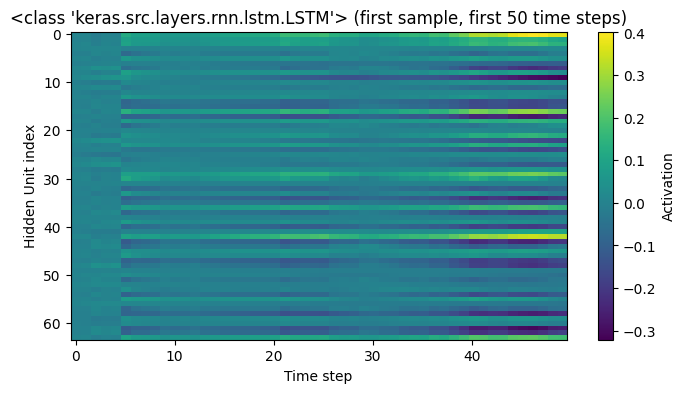

Architecture: <class 'keras.src.layers.rnn.lstm.LSTM'>, Hidden layers: [64, 16], Dropout: 0.2, L2: 0.001, Acc: 0.8505, Loss: 0.3897, AUC: 0.8692


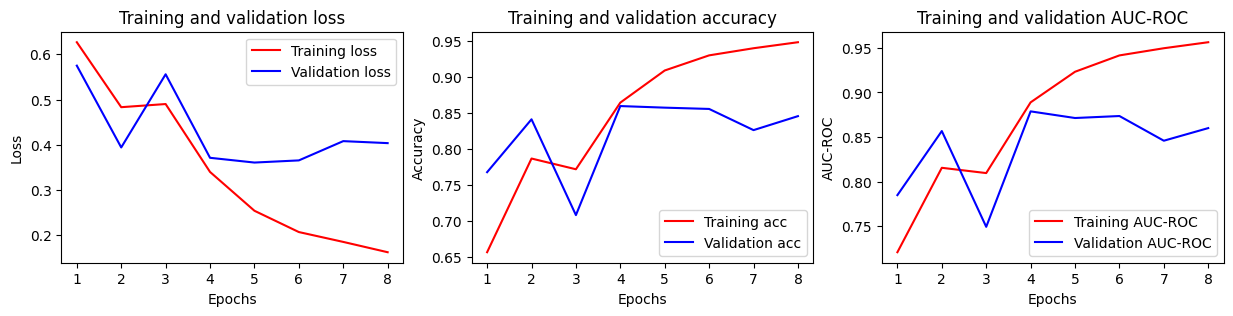

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 145s 440ms/step - auc: 0.6110 - binary_accuracy: 0.5492 - loss: 1.2897 - val_auc: 0.8526 - val_binary_accuracy: 0.8272 - val_loss: 0.4075
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 136s 432ms/step - auc: 0.8881 - binary_accuracy: 0.8674 - loss: 0.3557 - val_auc: 0.8789 - val_binary_accuracy: 0.8610 - val_loss: 0.3394
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 137s 436ms/step - auc: 0.9270 - binary_accuracy: 0.9127 - loss: 0.2557 - val_auc: 0.8836 - val_binary_accuracy: 0.8648 - val_loss: 0.3424
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 139s 444ms/step - auc: 0.9436 - binary_accuracy: 0.9316 - loss: 0.2083 - val_auc: 0.8756 - val_binary_accuracy: 0.8606 - val_loss: 0.3749
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 448ms/step - auc: 0.9519 - binary_accuracy: 0.9429 - loss: 0.1820 - val_auc: 0.8747 - val_binary_accuracy: 0.8572 - val_loss: 0.3548
Layer 0 output shape: (64, 250, 64)
Layer 1 output shape: (64, 16)
Layer 2 output shape: (64, 64)
Layer 3 outp

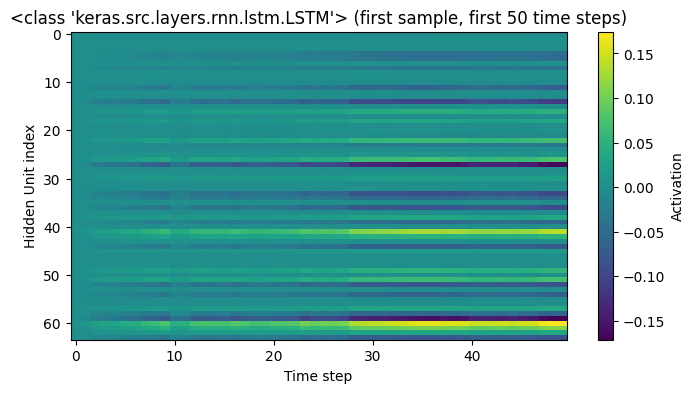

Architecture: <class 'keras.src.layers.rnn.lstm.LSTM'>, Hidden layers: [64, 16], Dropout: 0.5, L2: 0.01, Acc: 0.8514, Loss: 0.3713, AUC: 0.8702


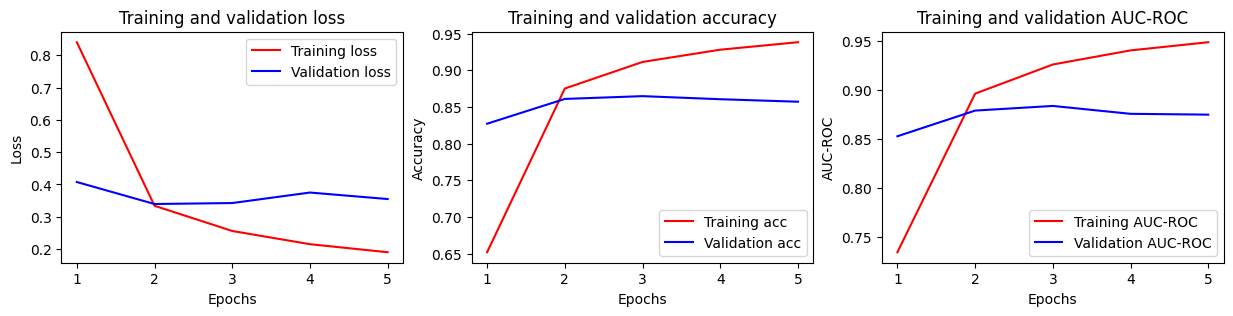

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 147s 446ms/step - auc: 0.5412 - binary_accuracy: 0.5194 - loss: 0.7545 - val_auc: 0.8197 - val_binary_accuracy: 0.7848 - val_loss: 0.5164
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 448ms/step - auc: 0.8206 - binary_accuracy: 0.7967 - loss: 0.4840 - val_auc: 0.8430 - val_binary_accuracy: 0.8296 - val_loss: 0.4489
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 453ms/step - auc: 0.8939 - binary_accuracy: 0.8718 - loss: 0.3336 - val_auc: 0.8767 - val_binary_accuracy: 0.8614 - val_loss: 0.3606
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 202s 452ms/step - auc: 0.9304 - binary_accuracy: 0.9151 - loss: 0.2455 - val_auc: 0.8826 - val_binary_accuracy: 0.8644 - val_loss: 0.3561
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 201s 448ms/step - auc: 0.9450 - binary_accuracy: 0.9312 - loss: 0.2009 - val_auc: 0.8824 - val_binary_accuracy: 0.8678 - val_loss: 0.3601
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 448ms/step - auc: 0.9569 - binary_accuracy: 0.9463 - loss: 0.1697

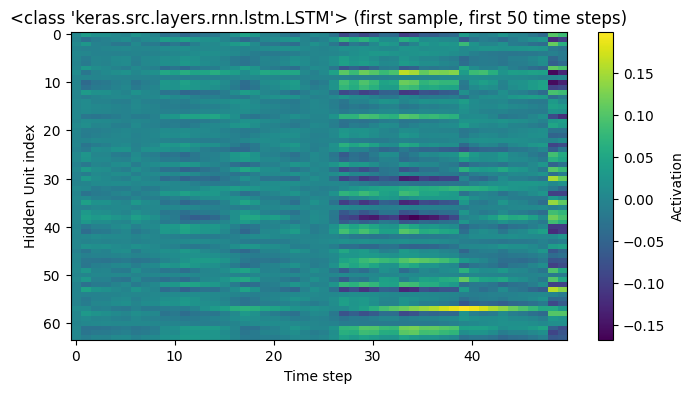

Architecture: <class 'keras.src.layers.rnn.lstm.LSTM'>, Hidden layers: [64, 16], Dropout: 0.5, L2: 0.001, Acc: 0.8498, Loss: 0.3942, AUC: 0.8660


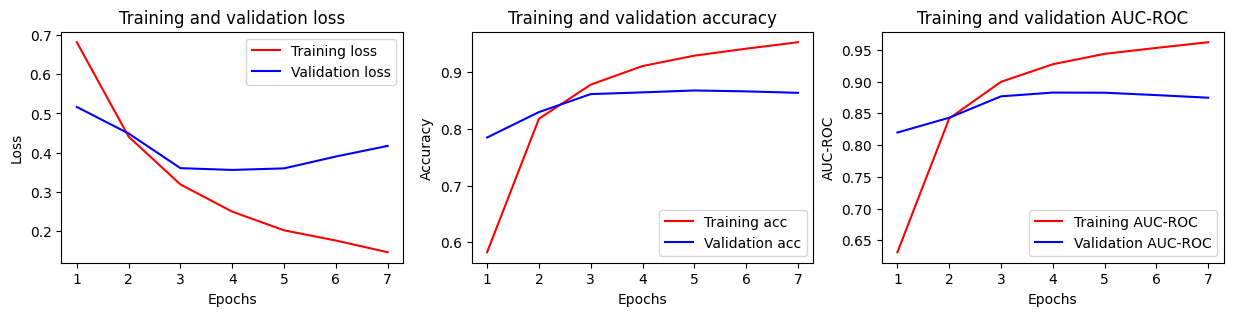

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 135s 411ms/step - auc: 0.6868 - binary_accuracy: 0.6563 - loss: 0.9707 - val_auc: 0.8377 - val_binary_accuracy: 0.8138 - val_loss: 0.4210
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 411ms/step - auc: 0.9032 - binary_accuracy: 0.8812 - loss: 0.3126 - val_auc: 0.8357 - val_binary_accuracy: 0.7994 - val_loss: 0.3992
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 414ms/step - auc: 0.9290 - binary_accuracy: 0.9131 - loss: 0.2427 - val_auc: 0.8641 - val_binary_accuracy: 0.8518 - val_loss: 0.3717
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 132s 419ms/step - auc: 0.9465 - binary_accuracy: 0.9370 - loss: 0.1891 - val_auc: 0.8724 - val_binary_accuracy: 0.8540 - val_loss: 0.3421
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 413ms/step - auc: 0.9537 - binary_accuracy: 0.9436 - loss: 0.1714 - val_auc: 0.8659 - val_binary_accuracy: 0.8556 - val_loss: 0.3804
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 129s 412ms/step - auc: 0.9633 - binary_accuracy: 0.9556 - loss: 0.1405

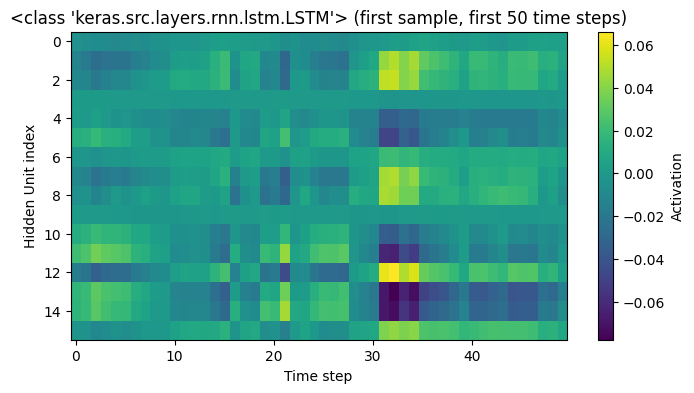

Architecture: <class 'keras.src.layers.rnn.lstm.LSTM'>, Hidden layers: [16, 64], Dropout: 0.2, L2: 0.01, Acc: 0.8428, Loss: 0.4605, AUC: 0.8531


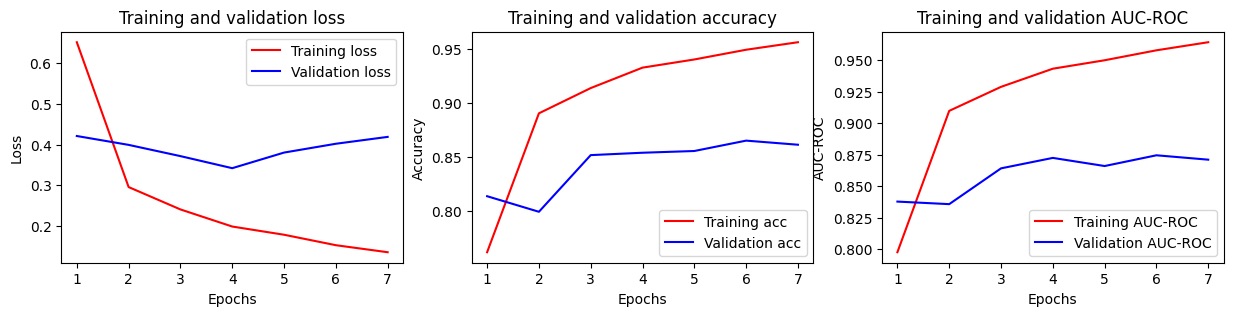

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 139s 418ms/step - auc: 0.6738 - binary_accuracy: 0.6379 - loss: 0.6306 - val_auc: 0.8840 - val_binary_accuracy: 0.8556 - val_loss: 0.3548
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 132s 421ms/step - auc: 0.9164 - binary_accuracy: 0.8972 - loss: 0.2770 - val_auc: 0.8898 - val_binary_accuracy: 0.8650 - val_loss: 0.3303
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 414ms/step - auc: 0.9429 - binary_accuracy: 0.9272 - loss: 0.2037 - val_auc: 0.8779 - val_binary_accuracy: 0.8598 - val_loss: 0.3534
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 419ms/step - auc: 0.9575 - binary_accuracy: 0.9463 - loss: 0.1608 - val_auc: 0.8476 - val_binary_accuracy: 0.8218 - val_loss: 0.3905
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 415ms/step - auc: 0.9642 - binary_accuracy: 0.9531 - loss: 0.1431 - val_auc: 0.8723 - val_binary_accuracy: 0.8638 - val_loss: 0.4578
Layer 0 output shape: (64, 250, 16)
Layer 1 output shape: (64, 64)
Layer 2 output shape: (64, 64)
Layer 3 outp

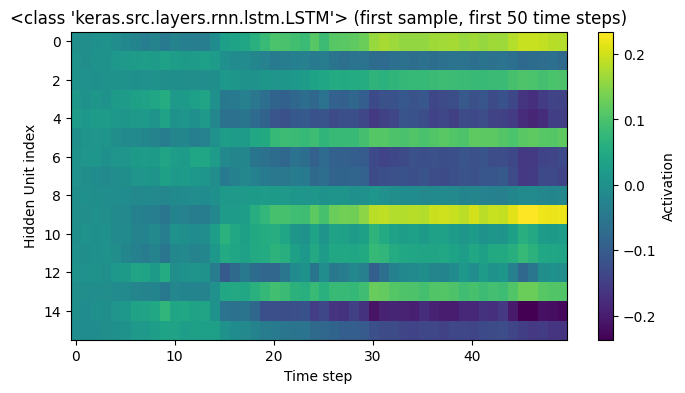

Architecture: <class 'keras.src.layers.rnn.lstm.LSTM'>, Hidden layers: [16, 64], Dropout: 0.2, L2: 0.001, Acc: 0.8530, Loss: 0.3493, AUC: 0.8831


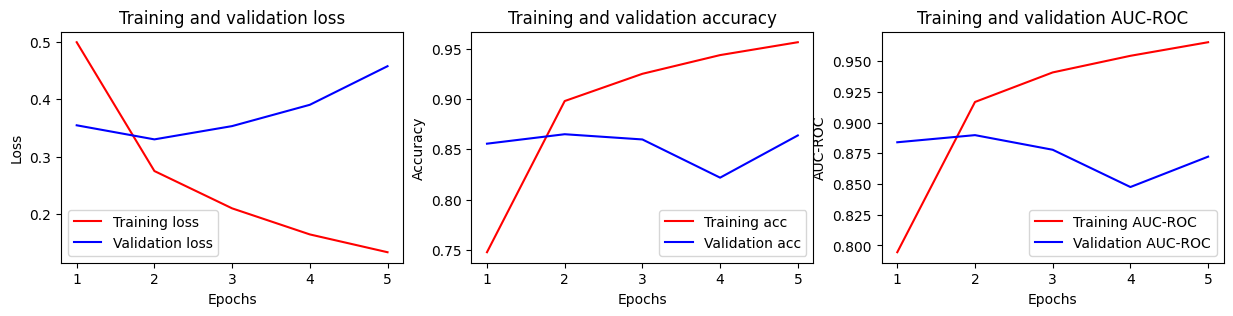

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 138s 415ms/step - auc: 0.5973 - binary_accuracy: 0.5581 - loss: 1.0570 - val_auc: 0.8623 - val_binary_accuracy: 0.8354 - val_loss: 0.3693
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 131s 416ms/step - auc: 0.8990 - binary_accuracy: 0.8775 - loss: 0.3218 - val_auc: 0.8915 - val_binary_accuracy: 0.8624 - val_loss: 0.3360
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 413ms/step - auc: 0.9330 - binary_accuracy: 0.9171 - loss: 0.2415 - val_auc: 0.8878 - val_binary_accuracy: 0.8656 - val_loss: 0.3391
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 415ms/step - auc: 0.9510 - binary_accuracy: 0.9394 - loss: 0.1895 - val_auc: 0.8817 - val_binary_accuracy: 0.8724 - val_loss: 0.3571
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 415ms/step - auc: 0.9599 - binary_accuracy: 0.9515 - loss: 0.1574 - val_auc: 0.8511 - val_binary_accuracy: 0.8426 - val_loss: 0.4855
Layer 0 output shape: (64, 250, 16)
Layer 1 output shape: (64, 64)
Layer 2 output shape: (64, 64)
Layer 3 outp

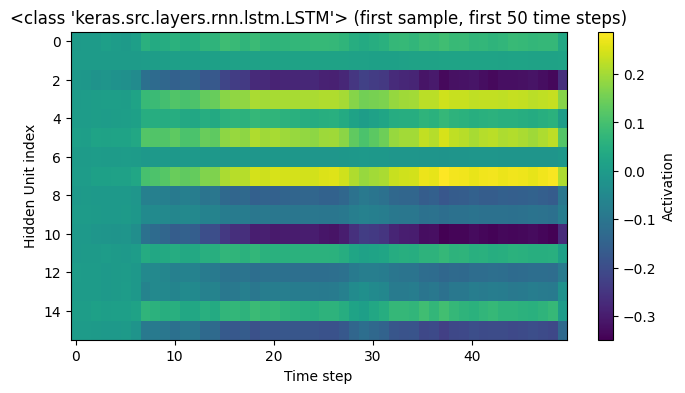

Architecture: <class 'keras.src.layers.rnn.lstm.LSTM'>, Hidden layers: [16, 64], Dropout: 0.5, L2: 0.01, Acc: 0.8493, Loss: 0.4054, AUC: 0.8608


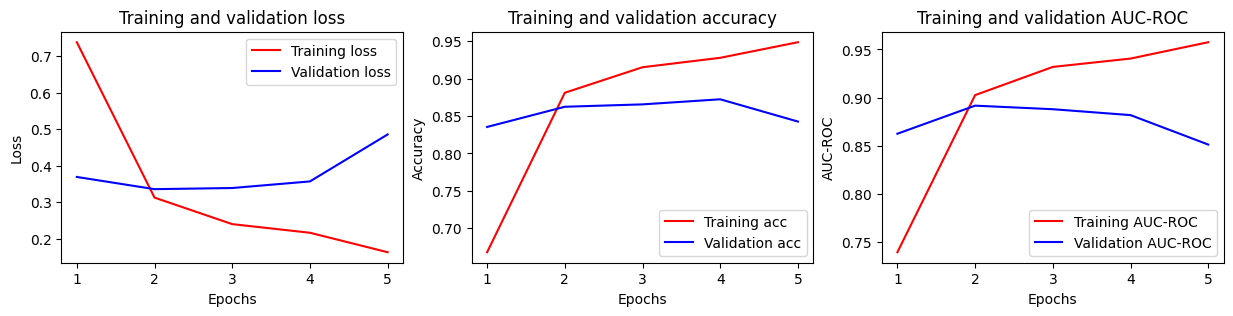

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 135s 408ms/step - auc: 0.7358 - binary_accuracy: 0.6647 - loss: 0.6016 - val_auc: 0.8831 - val_binary_accuracy: 0.8620 - val_loss: 0.3424
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 128s 406ms/step - auc: 0.9144 - binary_accuracy: 0.8951 - loss: 0.2826 - val_auc: 0.8738 - val_binary_accuracy: 0.8414 - val_loss: 0.3429
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 129s 412ms/step - auc: 0.9363 - binary_accuracy: 0.9220 - loss: 0.2229 - val_auc: 0.8824 - val_binary_accuracy: 0.8580 - val_loss: 0.3626
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 410ms/step - auc: 0.9566 - binary_accuracy: 0.9460 - loss: 0.1644 - val_auc: 0.8700 - val_binary_accuracy: 0.8580 - val_loss: 0.4403
Layer 0 output shape: (64, 250, 16)
Layer 1 output shape: (64, 64)
Layer 2 output shape: (64, 64)
Layer 3 output shape: (64, 1)


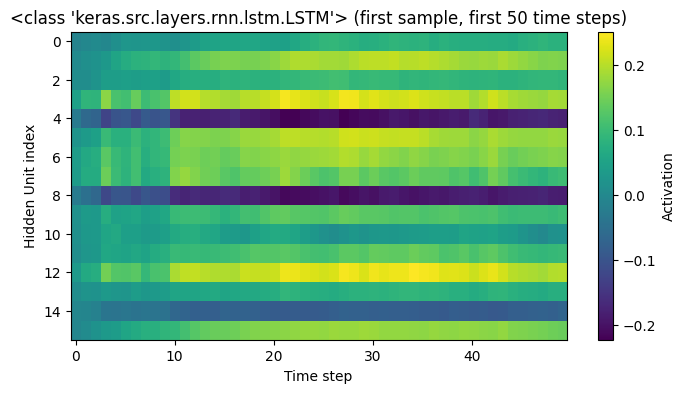

Architecture: <class 'keras.src.layers.rnn.lstm.LSTM'>, Hidden layers: [16, 64], Dropout: 0.5, L2: 0.001, Acc: 0.8554, Loss: 0.3587, AUC: 0.8778


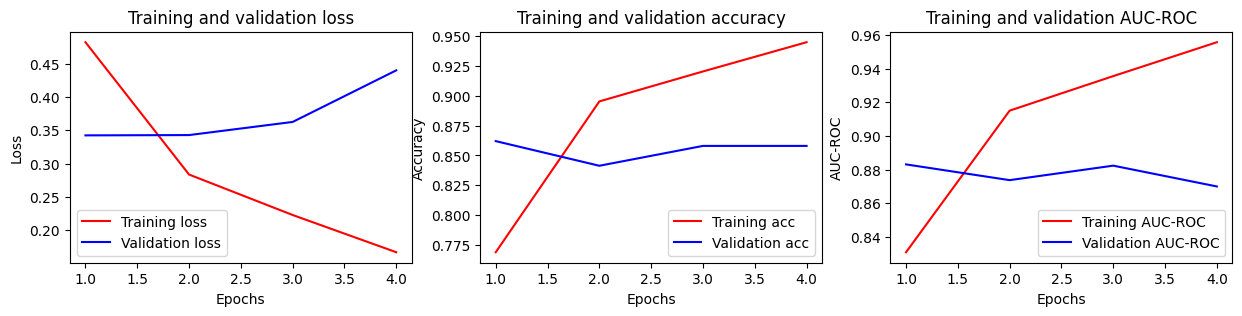

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 98s 299ms/step - auc: 0.6717 - binary_accuracy: 0.6408 - loss: 0.9421 - val_auc: 0.8511 - val_binary_accuracy: 0.7862 - val_loss: 0.4607
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 89s 283ms/step - auc: 0.9042 - binary_accuracy: 0.8809 - loss: 0.3118 - val_auc: 0.8886 - val_binary_accuracy: 0.8704 - val_loss: 0.3142
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 88s 281ms/step - auc: 0.9305 - binary_accuracy: 0.9166 - loss: 0.2302 - val_auc: 0.8872 - val_binary_accuracy: 0.8694 - val_loss: 0.3226
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 281ms/step - auc: 0.9425 - binary_accuracy: 0.9327 - loss: 0.1955 - val_auc: 0.8593 - val_binary_accuracy: 0.8504 - val_loss: 0.4183
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 279ms/step - auc: 0.9559 - binary_accuracy: 0.9471 - loss: 0.1629 - val_auc: 0.8745 - val_binary_accuracy: 0.8612 - val_loss: 0.3748
Layer 0 output shape: (64, 64)
Layer 1 output shape: (64, 64)
Layer 2 output shape: (64, 1)
⚠️ Skipping visualiza

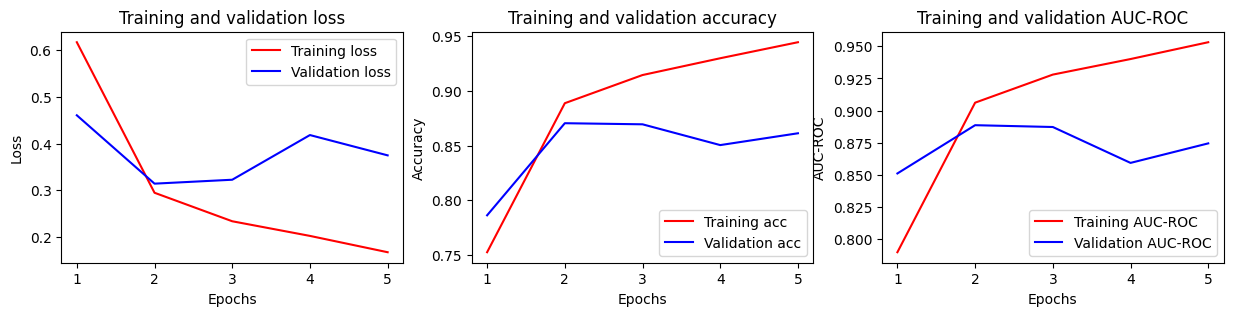

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 94s 281ms/step - auc: 0.7156 - binary_accuracy: 0.6507 - loss: 0.6045 - val_auc: 0.8499 - val_binary_accuracy: 0.8062 - val_loss: 0.3809
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 284ms/step - auc: 0.9099 - binary_accuracy: 0.8910 - loss: 0.2880 - val_auc: 0.8912 - val_binary_accuracy: 0.8710 - val_loss: 0.3195
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 287ms/step - auc: 0.9387 - binary_accuracy: 0.9248 - loss: 0.2113 - val_auc: 0.8788 - val_binary_accuracy: 0.8614 - val_loss: 0.3294
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 282ms/step - auc: 0.9514 - binary_accuracy: 0.9406 - loss: 0.1705 - val_auc: 0.8676 - val_binary_accuracy: 0.8488 - val_loss: 0.3681
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 145s 295ms/step - auc: 0.9560 - binary_accuracy: 0.9446 - loss: 0.1572 - val_auc: 0.8738 - val_binary_accuracy: 0.8630 - val_loss: 0.4013
Layer 0 output shape: (64, 64)
Layer 1 output shape: (64, 64)
Layer 2 output shape: (64, 1)
⚠️ Skipping visuali

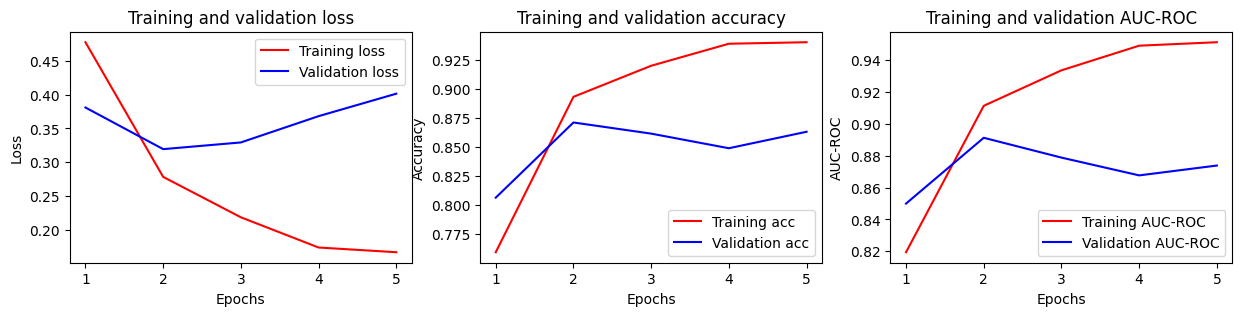

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 96s 290ms/step - auc: 0.6462 - binary_accuracy: 0.6146 - loss: 0.9782 - val_auc: 0.8805 - val_binary_accuracy: 0.8612 - val_loss: 0.3651
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 288ms/step - auc: 0.9021 - binary_accuracy: 0.8830 - loss: 0.3068 - val_auc: 0.8834 - val_binary_accuracy: 0.8696 - val_loss: 0.3363
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 287ms/step - auc: 0.9333 - binary_accuracy: 0.9209 - loss: 0.2264 - val_auc: 0.8657 - val_binary_accuracy: 0.8496 - val_loss: 0.3491
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 283ms/step - auc: 0.9375 - binary_accuracy: 0.9259 - loss: 0.2093 - val_auc: 0.8733 - val_binary_accuracy: 0.8558 - val_loss: 0.3798
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 91s 286ms/step - auc: 0.9460 - binary_accuracy: 0.9348 - loss: 0.1865 - val_auc: 0.8776 - val_binary_accuracy: 0.8658 - val_loss: 0.3716
Layer 0 output shape: (64, 64)
Layer 1 output shape: (64, 64)
Layer 2 output shape: (64, 1)
⚠️ Skipping visualiz

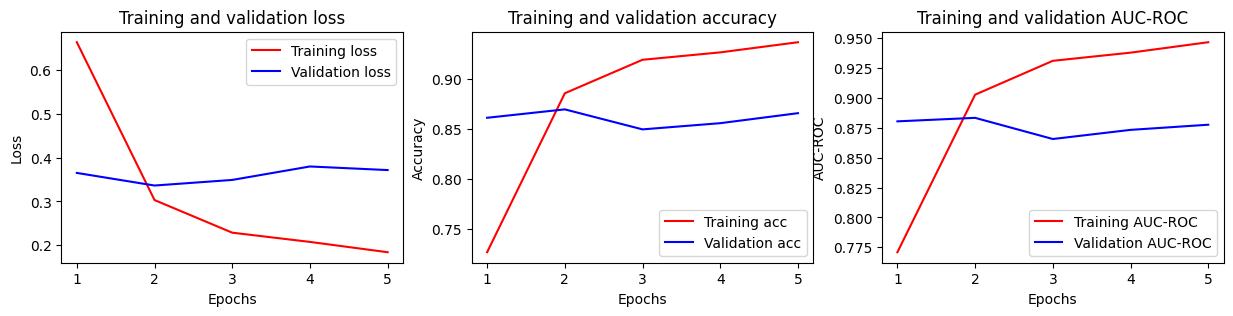

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 95s 287ms/step - auc: 0.6810 - binary_accuracy: 0.6252 - loss: 0.6406 - val_auc: 0.8889 - val_binary_accuracy: 0.8682 - val_loss: 0.3335
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 285ms/step - auc: 0.9024 - binary_accuracy: 0.8781 - loss: 0.3102 - val_auc: 0.8953 - val_binary_accuracy: 0.8740 - val_loss: 0.3080
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 282ms/step - auc: 0.9343 - binary_accuracy: 0.9221 - loss: 0.2234 - val_auc: 0.8769 - val_binary_accuracy: 0.8610 - val_loss: 0.3353
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 146s 296ms/step - auc: 0.9494 - binary_accuracy: 0.9412 - loss: 0.1782 - val_auc: 0.8760 - val_binary_accuracy: 0.8550 - val_loss: 0.3538
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 138s 284ms/step - auc: 0.9634 - binary_accuracy: 0.9541 - loss: 0.1416 - val_auc: 0.8630 - val_binary_accuracy: 0.8552 - val_loss: 0.4564
Layer 0 output shape: (64, 64)
Layer 1 output shape: (64, 64)
Layer 2 output shape: (64, 1)
⚠️ Skipping visuali

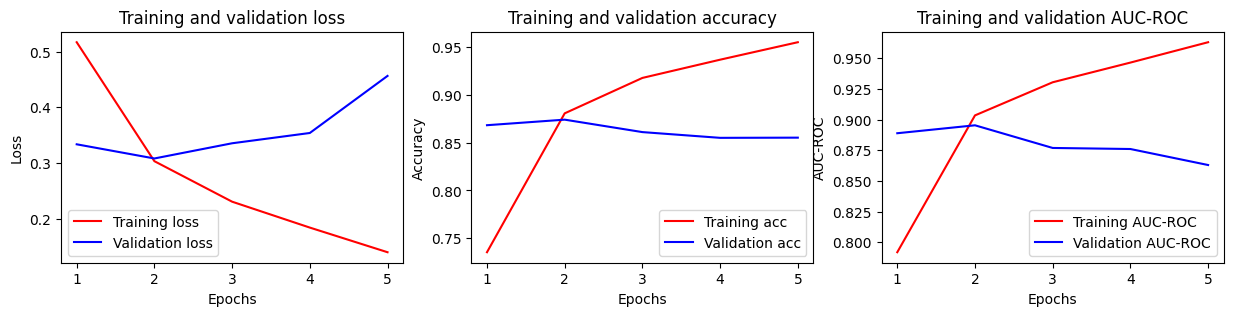

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 157s 474ms/step - auc: 0.6252 - binary_accuracy: 0.5937 - loss: 1.2420 - val_auc: 0.8809 - val_binary_accuracy: 0.8550 - val_loss: 0.3654
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 201s 472ms/step - auc: 0.8999 - binary_accuracy: 0.8766 - loss: 0.3183 - val_auc: 0.8602 - val_binary_accuracy: 0.8316 - val_loss: 0.3655
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 202s 476ms/step - auc: 0.9266 - binary_accuracy: 0.9112 - loss: 0.2486 - val_auc: 0.8728 - val_binary_accuracy: 0.8496 - val_loss: 0.3396
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 204s 482ms/step - auc: 0.9416 - binary_accuracy: 0.9283 - loss: 0.2079 - val_auc: 0.8460 - val_binary_accuracy: 0.8258 - val_loss: 0.4951
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 202s 483ms/step - auc: 0.9469 - binary_accuracy: 0.9318 - loss: 0.1977 - val_auc: 0.8753 - val_binary_accuracy: 0.8582 - val_loss: 0.3573
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 148s 471ms/step - auc: 0.9626 - binary_accuracy: 0.9548 - loss: 0.1441

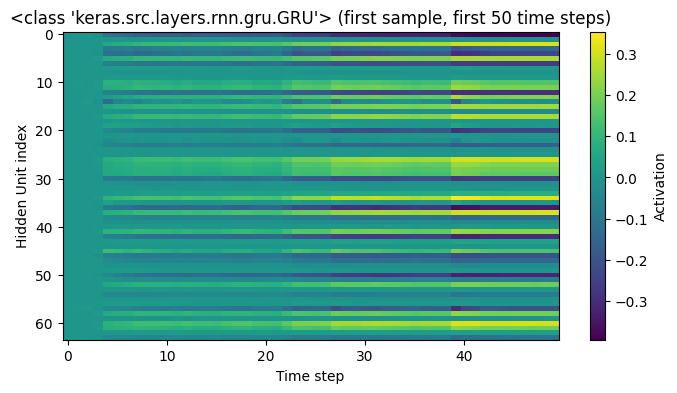

Architecture: <class 'keras.src.layers.rnn.gru.GRU'>, Hidden layers: [64, 16], Dropout: 0.2, L2: 0.01, Acc: 0.8430, Loss: 0.4820, AUC: 0.8529


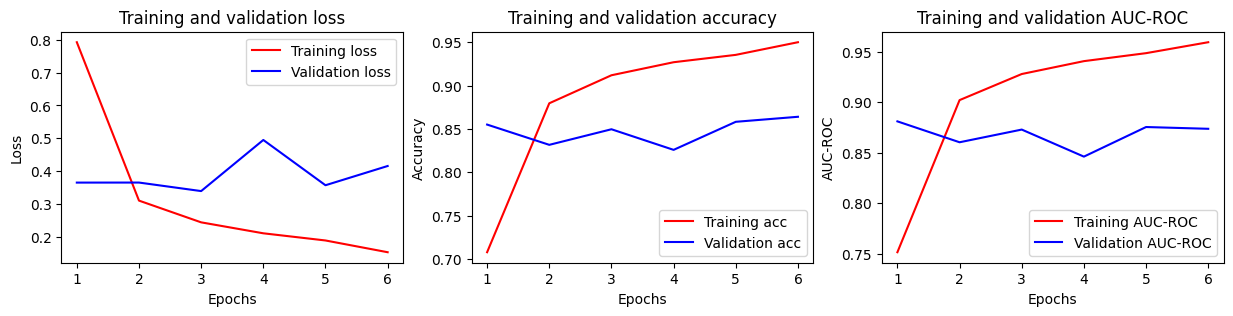

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 156s 474ms/step - auc: 0.6286 - binary_accuracy: 0.5844 - loss: 0.7050 - val_auc: 0.8341 - val_binary_accuracy: 0.7940 - val_loss: 0.4706
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 207s 490ms/step - auc: 0.8822 - binary_accuracy: 0.8593 - loss: 0.3609 - val_auc: 0.8854 - val_binary_accuracy: 0.8570 - val_loss: 0.3370
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 199s 479ms/step - auc: 0.9238 - binary_accuracy: 0.9053 - loss: 0.2483 - val_auc: 0.8842 - val_binary_accuracy: 0.8658 - val_loss: 0.3461
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 152s 481ms/step - auc: 0.9424 - binary_accuracy: 0.9284 - loss: 0.1981 - val_auc: 0.8838 - val_binary_accuracy: 0.8670 - val_loss: 0.3406
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 149s 474ms/step - auc: 0.9654 - binary_accuracy: 0.9552 - loss: 0.1397 - val_auc: 0.8792 - val_binary_accuracy: 0.8690 - val_loss: 0.3871
Layer 0 output shape: (64, 250, 64)
Layer 1 output shape: (64, 16)
Layer 2 output shape: (64, 64)
Layer 3 outp

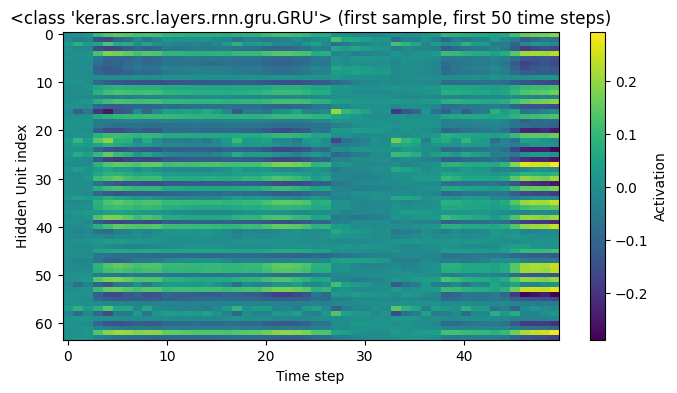

Architecture: <class 'keras.src.layers.rnn.gru.GRU'>, Hidden layers: [64, 16], Dropout: 0.2, L2: 0.001, Acc: 0.8505, Loss: 0.4400, AUC: 0.8614


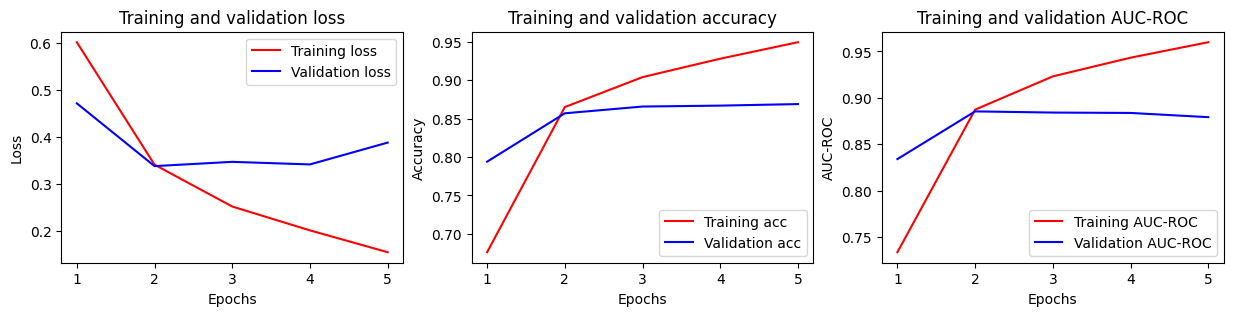

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 158s 478ms/step - auc: 0.5211 - binary_accuracy: 0.5118 - loss: 1.2947 - val_auc: 0.8198 - val_binary_accuracy: 0.7914 - val_loss: 0.5422
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 203s 481ms/step - auc: 0.8570 - binary_accuracy: 0.8265 - loss: 0.4121 - val_auc: 0.8839 - val_binary_accuracy: 0.8642 - val_loss: 0.3357
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 205s 491ms/step - auc: 0.9226 - binary_accuracy: 0.9060 - loss: 0.2627 - val_auc: 0.8864 - val_binary_accuracy: 0.8644 - val_loss: 0.3487
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 151s 478ms/step - auc: 0.9443 - binary_accuracy: 0.9294 - loss: 0.2088 - val_auc: 0.8800 - val_binary_accuracy: 0.8688 - val_loss: 0.3577
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 203s 484ms/step - auc: 0.9540 - binary_accuracy: 0.9434 - loss: 0.1752 - val_auc: 0.8824 - val_binary_accuracy: 0.8698 - val_loss: 0.3516
Layer 0 output shape: (64, 250, 64)
Layer 1 output shape: (64, 16)
Layer 2 output shape: (64, 64)
Layer 3 outp

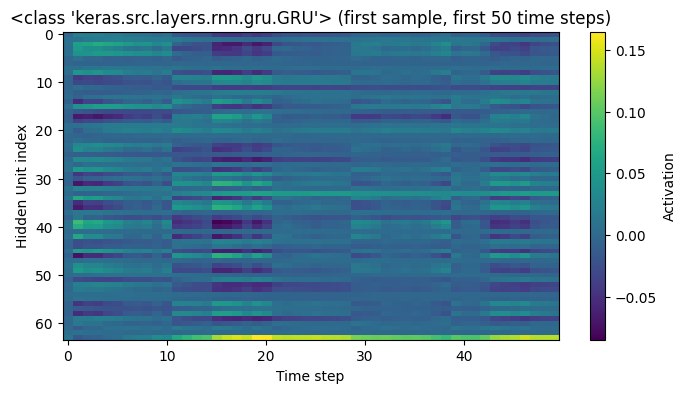

Architecture: <class 'keras.src.layers.rnn.gru.GRU'>, Hidden layers: [64, 16], Dropout: 0.5, L2: 0.01, Acc: 0.8512, Loss: 0.3971, AUC: 0.8650


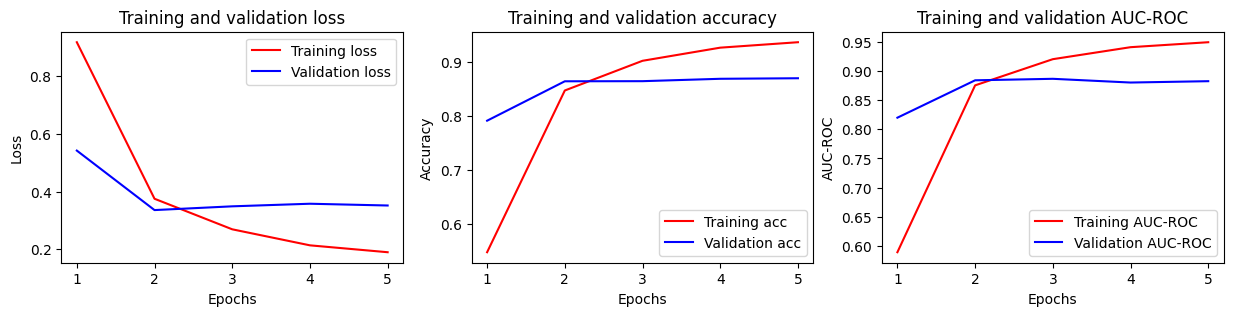

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 161s 490ms/step - auc: 0.5979 - binary_accuracy: 0.5269 - loss: 0.7377 - val_auc: 0.8524 - val_binary_accuracy: 0.8240 - val_loss: 0.4377
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 204s 497ms/step - auc: 0.8729 - binary_accuracy: 0.8480 - loss: 0.3793 - val_auc: 0.8831 - val_binary_accuracy: 0.8502 - val_loss: 0.3794
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 156s 496ms/step - auc: 0.9226 - binary_accuracy: 0.9057 - loss: 0.2647 - val_auc: 0.8885 - val_binary_accuracy: 0.8690 - val_loss: 0.3293
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 203s 499ms/step - auc: 0.9470 - binary_accuracy: 0.9345 - loss: 0.1955 - val_auc: 0.8797 - val_binary_accuracy: 0.8640 - val_loss: 0.3541
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 199s 489ms/step - auc: 0.9576 - binary_accuracy: 0.9481 - loss: 0.1587 - val_auc: 0.8756 - val_binary_accuracy: 0.8634 - val_loss: 0.3820
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 153s 488ms/step - auc: 0.9714 - binary_accuracy: 0.9646 - loss: 0.1171

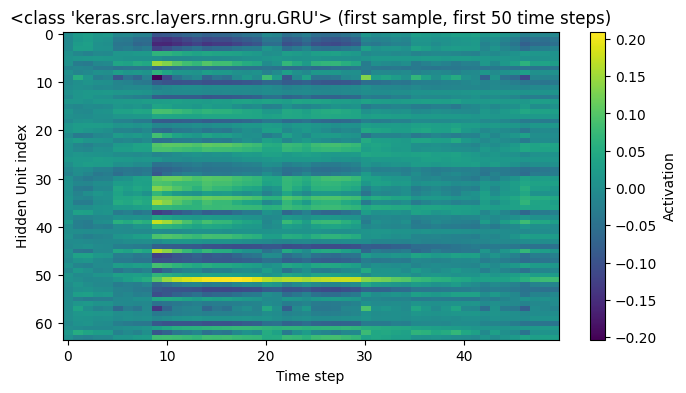

Architecture: <class 'keras.src.layers.rnn.gru.GRU'>, Hidden layers: [64, 16], Dropout: 0.5, L2: 0.001, Acc: 0.8574, Loss: 0.3549, AUC: 0.8774


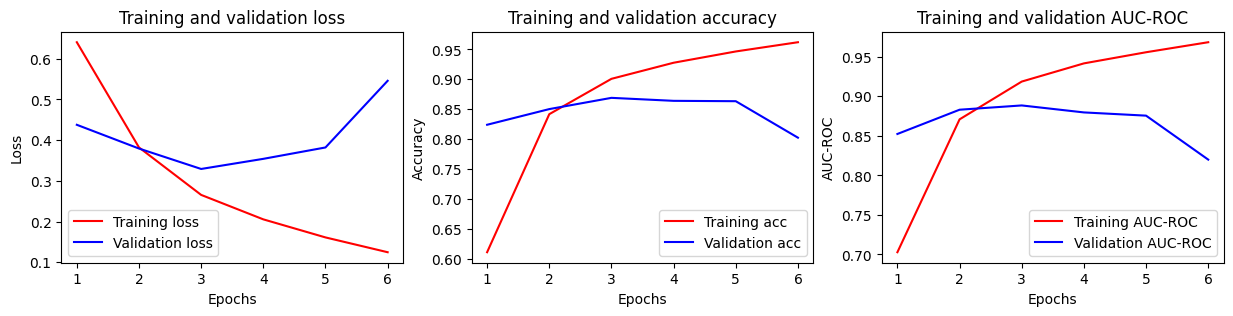

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 158s 477ms/step - auc: 0.6094 - binary_accuracy: 0.5802 - loss: 1.0121 - val_auc: 0.8329 - val_binary_accuracy: 0.8130 - val_loss: 0.4215
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 198s 466ms/step - auc: 0.8876 - binary_accuracy: 0.8649 - loss: 0.3437 - val_auc: 0.8838 - val_binary_accuracy: 0.8606 - val_loss: 0.3688
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 150s 476ms/step - auc: 0.9304 - binary_accuracy: 0.9148 - loss: 0.2396 - val_auc: 0.8897 - val_binary_accuracy: 0.8698 - val_loss: 0.3259
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 200s 470ms/step - auc: 0.9489 - binary_accuracy: 0.9373 - loss: 0.1820 - val_auc: 0.8802 - val_binary_accuracy: 0.8676 - val_loss: 0.3586
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 203s 472ms/step - auc: 0.9593 - binary_accuracy: 0.9484 - loss: 0.1534 - val_auc: 0.8732 - val_binary_accuracy: 0.8582 - val_loss: 0.4231
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 152s 483ms/step - auc: 0.9662 - binary_accuracy: 0.9571 - loss: 0.1331

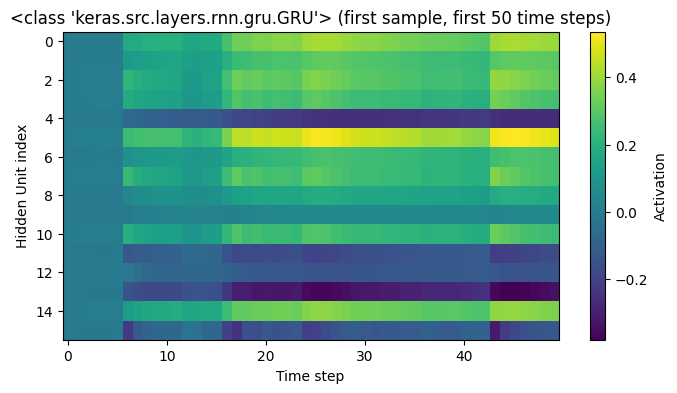

Architecture: <class 'keras.src.layers.rnn.gru.GRU'>, Hidden layers: [16, 64], Dropout: 0.2, L2: 0.01, Acc: 0.8498, Loss: 0.3650, AUC: 0.8681


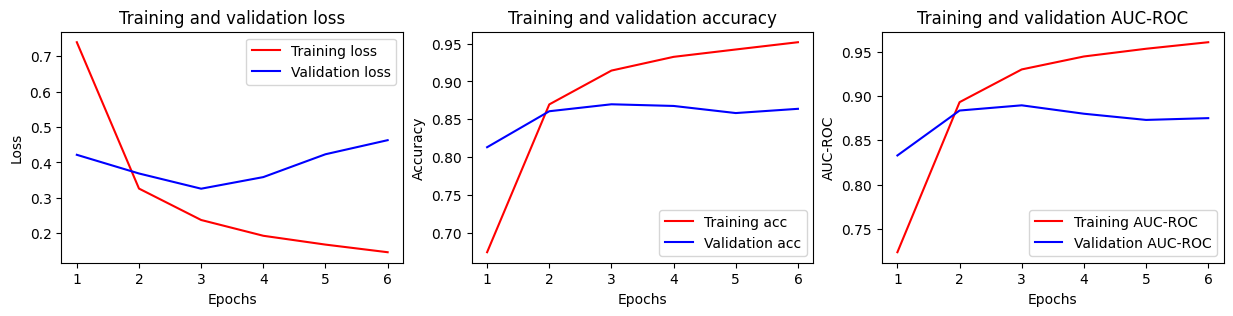

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 160s 484ms/step - auc: 0.6152 - binary_accuracy: 0.5807 - loss: 0.6760 - val_auc: 0.8550 - val_binary_accuracy: 0.8184 - val_loss: 0.4189
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 147s 466ms/step - auc: 0.8879 - binary_accuracy: 0.8650 - loss: 0.3372 - val_auc: 0.8773 - val_binary_accuracy: 0.8560 - val_loss: 0.3363
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 204s 476ms/step - auc: 0.9296 - binary_accuracy: 0.9110 - loss: 0.2382 - val_auc: 0.8893 - val_binary_accuracy: 0.8644 - val_loss: 0.3261
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 198s 463ms/step - auc: 0.9487 - binary_accuracy: 0.9357 - loss: 0.1856 - val_auc: 0.8806 - val_binary_accuracy: 0.8598 - val_loss: 0.3514
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 162s 516ms/step - auc: 0.9580 - binary_accuracy: 0.9471 - loss: 0.1523 - val_auc: 0.8803 - val_binary_accuracy: 0.8674 - val_loss: 0.3747
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 149s 473ms/step - auc: 0.9639 - binary_accuracy: 0.9535 - loss: 0.1347

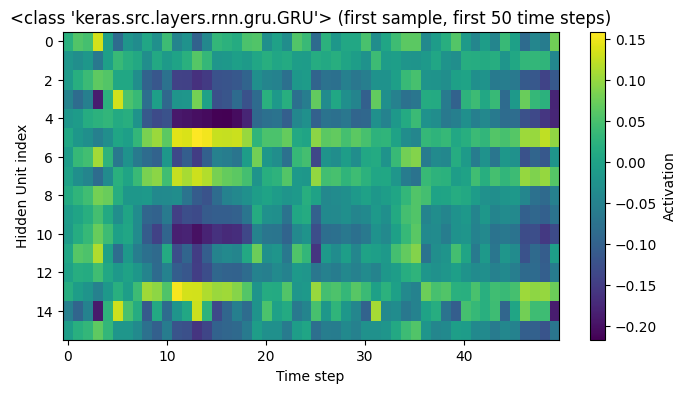

Architecture: <class 'keras.src.layers.rnn.gru.GRU'>, Hidden layers: [16, 64], Dropout: 0.2, L2: 0.001, Acc: 0.8469, Loss: 0.4235, AUC: 0.8612


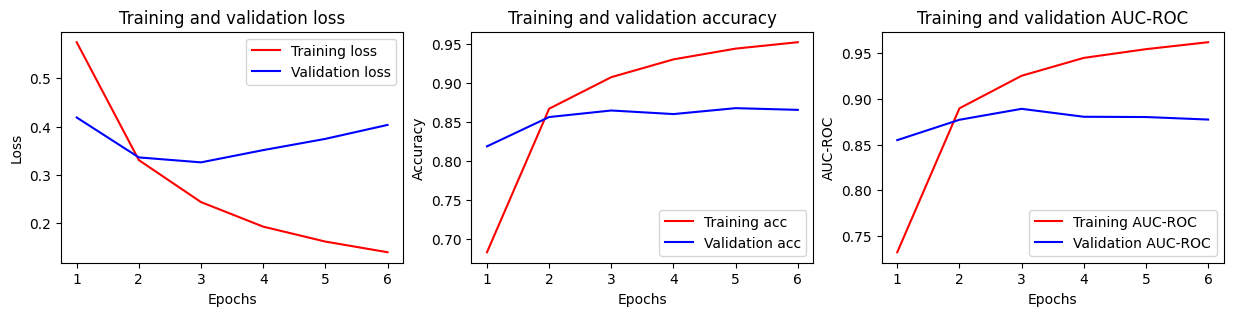

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 153s 464ms/step - auc: 0.6616 - binary_accuracy: 0.5884 - loss: 0.9929 - val_auc: 0.8859 - val_binary_accuracy: 0.8652 - val_loss: 0.3446
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 203s 466ms/step - auc: 0.8970 - binary_accuracy: 0.8753 - loss: 0.3315 - val_auc: 0.8814 - val_binary_accuracy: 0.8542 - val_loss: 0.3681
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 202s 467ms/step - auc: 0.9320 - binary_accuracy: 0.9154 - loss: 0.2407 - val_auc: 0.8843 - val_binary_accuracy: 0.8686 - val_loss: 0.3523
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 205s 476ms/step - auc: 0.9482 - binary_accuracy: 0.9348 - loss: 0.1899 - val_auc: 0.8844 - val_binary_accuracy: 0.8674 - val_loss: 0.3565
Layer 0 output shape: (64, 250, 16)
Layer 1 output shape: (64, 64)
Layer 2 output shape: (64, 64)
Layer 3 output shape: (64, 1)


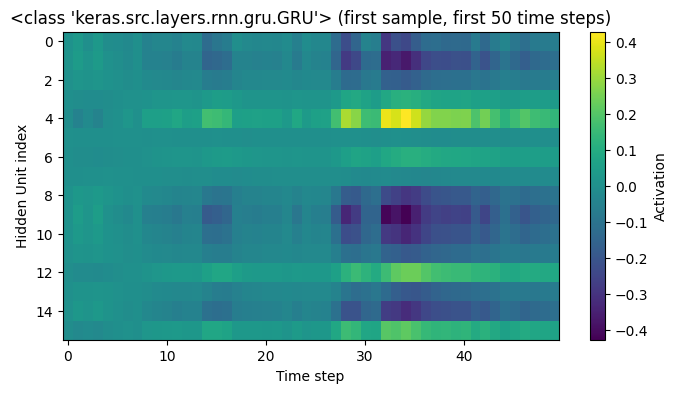

Architecture: <class 'keras.src.layers.rnn.gru.GRU'>, Hidden layers: [16, 64], Dropout: 0.5, L2: 0.01, Acc: 0.8546, Loss: 0.3822, AUC: 0.8712


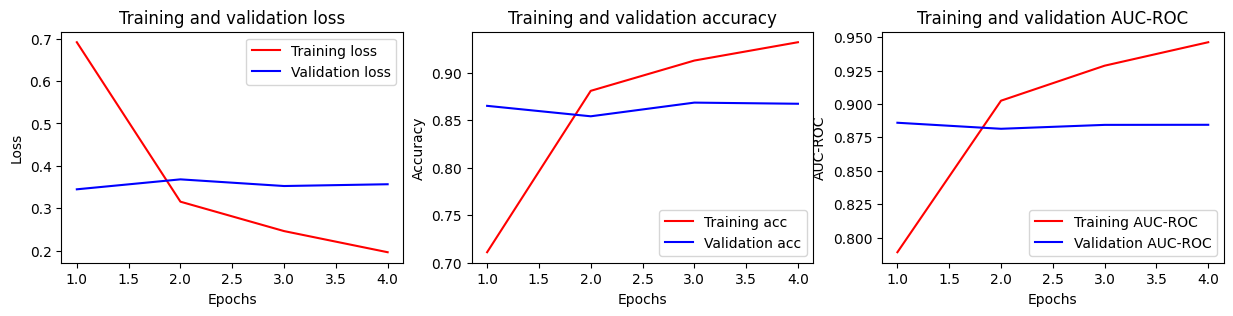

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 155s 468ms/step - auc: 0.6210 - binary_accuracy: 0.5567 - loss: 0.6920 - val_auc: 0.8327 - val_binary_accuracy: 0.7996 - val_loss: 0.4199
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 202s 468ms/step - auc: 0.8862 - binary_accuracy: 0.8585 - loss: 0.3427 - val_auc: 0.8868 - val_binary_accuracy: 0.8614 - val_loss: 0.3445
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 146s 464ms/step - auc: 0.9181 - binary_accuracy: 0.8959 - loss: 0.2617 - val_auc: 0.8857 - val_binary_accuracy: 0.8664 - val_loss: 0.3366
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 148s 472ms/step - auc: 0.9448 - binary_accuracy: 0.9279 - loss: 0.1997 - val_auc: 0.8839 - val_binary_accuracy: 0.8662 - val_loss: 0.3521
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 146s 466ms/step - auc: 0.9514 - binary_accuracy: 0.9363 - loss: 0.1740 - val_auc: 0.8679 - val_binary_accuracy: 0.8456 - val_loss: 0.3972
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 146s 465ms/step - auc: 0.9662 - binary_accuracy: 0.9552 - loss: 0.1309

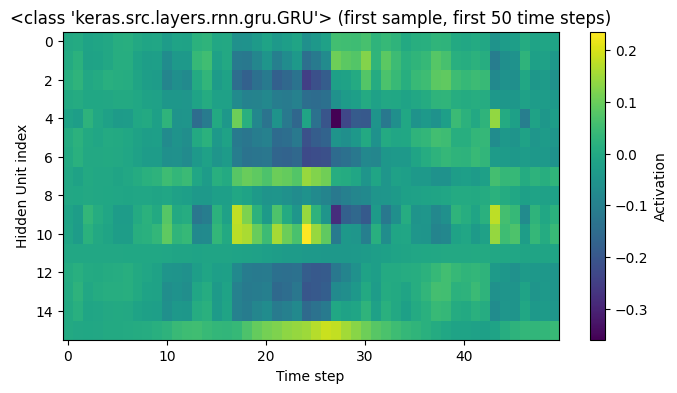

Architecture: <class 'keras.src.layers.rnn.gru.GRU'>, Hidden layers: [16, 64], Dropout: 0.5, L2: 0.001, Acc: 0.8463, Loss: 0.3676, AUC: 0.8692


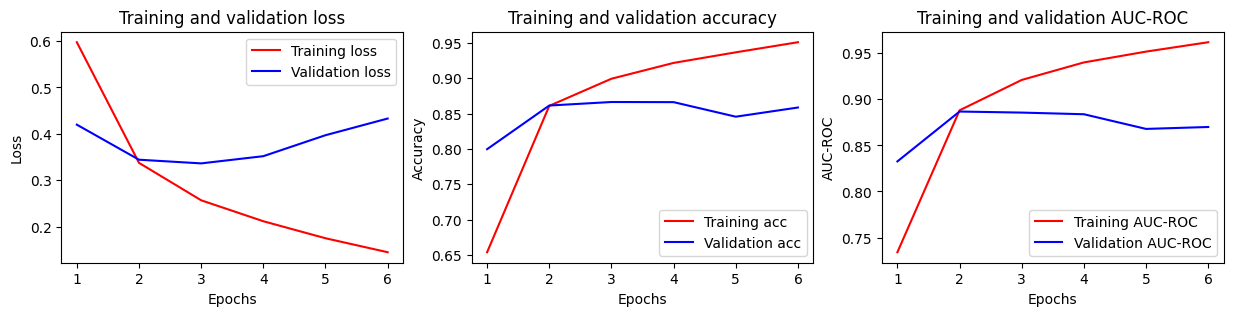

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 104s 315ms/step - auc: 0.5751 - binary_accuracy: 0.5338 - loss: 1.0310 - val_auc: 0.8493 - val_binary_accuracy: 0.8310 - val_loss: 0.4223
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 314ms/step - auc: 0.8707 - binary_accuracy: 0.8466 - loss: 0.3717 - val_auc: 0.8731 - val_binary_accuracy: 0.8540 - val_loss: 0.3366
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 311ms/step - auc: 0.9175 - binary_accuracy: 0.9011 - loss: 0.2605 - val_auc: 0.8356 - val_binary_accuracy: 0.8010 - val_loss: 0.3979
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 144s 316ms/step - auc: 0.9452 - binary_accuracy: 0.9324 - loss: 0.1959 - val_auc: 0.8514 - val_binary_accuracy: 0.8308 - val_loss: 0.3825
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 313ms/step - auc: 0.9541 - binary_accuracy: 0.9439 - loss: 0.1661 - val_auc: 0.8763 - val_binary_accuracy: 0.8656 - val_loss: 0.3654
Layer 0 output shape: (64, 64)
Layer 1 output shape: (64, 64)
Layer 2 output shape: (64, 1)
⚠️ Skipping visual

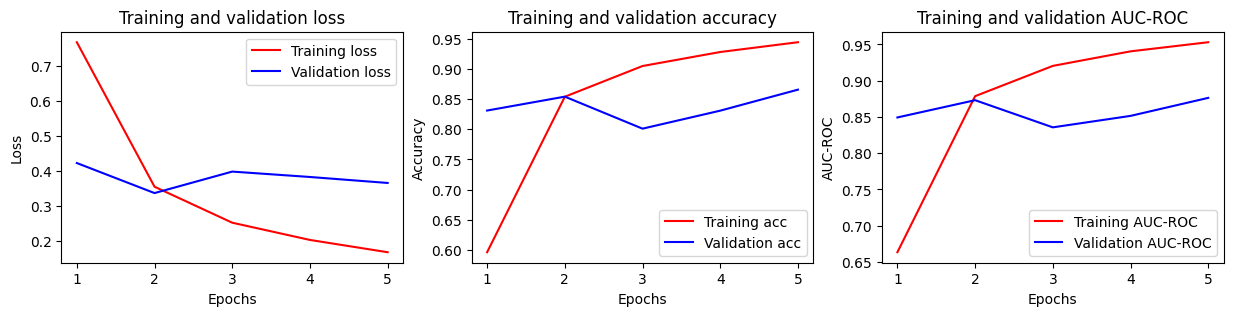

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 105s 321ms/step - auc: 0.6413 - binary_accuracy: 0.6125 - loss: 0.6449 - val_auc: 0.8884 - val_binary_accuracy: 0.8590 - val_loss: 0.3349
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 139s 313ms/step - auc: 0.9091 - binary_accuracy: 0.8861 - loss: 0.2910 - val_auc: 0.8886 - val_binary_accuracy: 0.8614 - val_loss: 0.3526
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 148s 332ms/step - auc: 0.9287 - binary_accuracy: 0.9106 - loss: 0.2381 - val_auc: 0.8724 - val_binary_accuracy: 0.8556 - val_loss: 0.3410
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 135s 310ms/step - auc: 0.9468 - binary_accuracy: 0.9349 - loss: 0.1851 - val_auc: 0.8831 - val_binary_accuracy: 0.8652 - val_loss: 0.3359
Layer 0 output shape: (64, 64)
Layer 1 output shape: (64, 64)
Layer 2 output shape: (64, 1)
⚠️ Skipping visualization: output is 2D (no sequence returned).
Architecture: <class 'keras.src.layers.rnn.gru.GRU'>, Hidden layers: [64], Dropout: 0.2, L2: 0.001, Acc: 0.8545, Loss: 0.3670, AUC: 

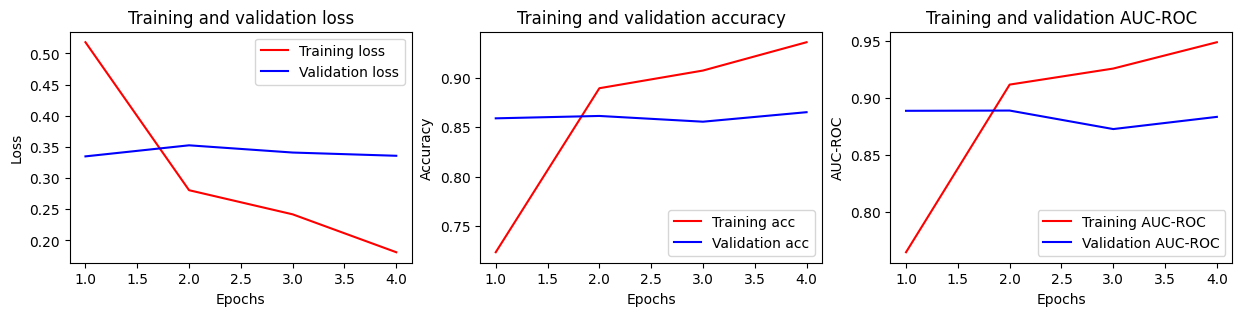

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 105s 319ms/step - auc: 0.5998 - binary_accuracy: 0.5595 - loss: 1.0085 - val_auc: 0.8572 - val_binary_accuracy: 0.8248 - val_loss: 0.3732
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 316ms/step - auc: 0.8856 - binary_accuracy: 0.8594 - loss: 0.3423 - val_auc: 0.8637 - val_binary_accuracy: 0.8408 - val_loss: 0.3492
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 98s 312ms/step - auc: 0.9277 - binary_accuracy: 0.9104 - loss: 0.2405 - val_auc: 0.8877 - val_binary_accuracy: 0.8716 - val_loss: 0.3438
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 144s 317ms/step - auc: 0.9474 - binary_accuracy: 0.9351 - loss: 0.1907 - val_auc: 0.8786 - val_binary_accuracy: 0.8608 - val_loss: 0.3535
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 146s 329ms/step - auc: 0.9592 - binary_accuracy: 0.9469 - loss: 0.1576 - val_auc: 0.8782 - val_binary_accuracy: 0.8634 - val_loss: 0.4040
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 139s 320ms/step - auc: 0.9646 - binary_accuracy: 0.9574 - loss: 0.1373 

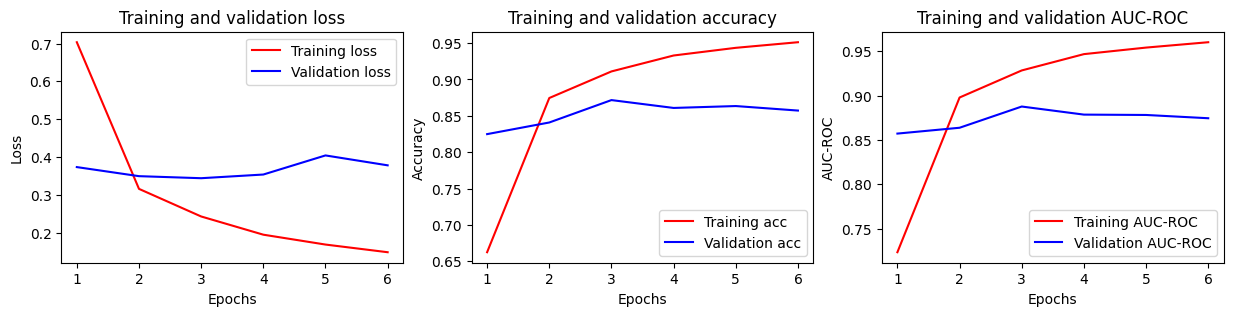

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 105s 320ms/step - auc: 0.6181 - binary_accuracy: 0.5675 - loss: 0.6815 - val_auc: 0.8748 - val_binary_accuracy: 0.8414 - val_loss: 0.3904
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 100s 318ms/step - auc: 0.8959 - binary_accuracy: 0.8712 - loss: 0.3194 - val_auc: 0.8947 - val_binary_accuracy: 0.8708 - val_loss: 0.3082
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 101s 320ms/step - auc: 0.9346 - binary_accuracy: 0.9180 - loss: 0.2262 - val_auc: 0.8837 - val_binary_accuracy: 0.8640 - val_loss: 0.3301
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 318ms/step - auc: 0.9567 - binary_accuracy: 0.9439 - loss: 0.1616 - val_auc: 0.8873 - val_binary_accuracy: 0.8718 - val_loss: 0.3480
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 320ms/step - auc: 0.9654 - binary_accuracy: 0.9567 - loss: 0.1316 - val_auc: 0.8764 - val_binary_accuracy: 0.8614 - val_loss: 0.3471
Layer 0 output shape: (64, 64)
Layer 1 output shape: (64, 64)
Layer 2 output shape: (64, 1)
⚠️ Skipping visual

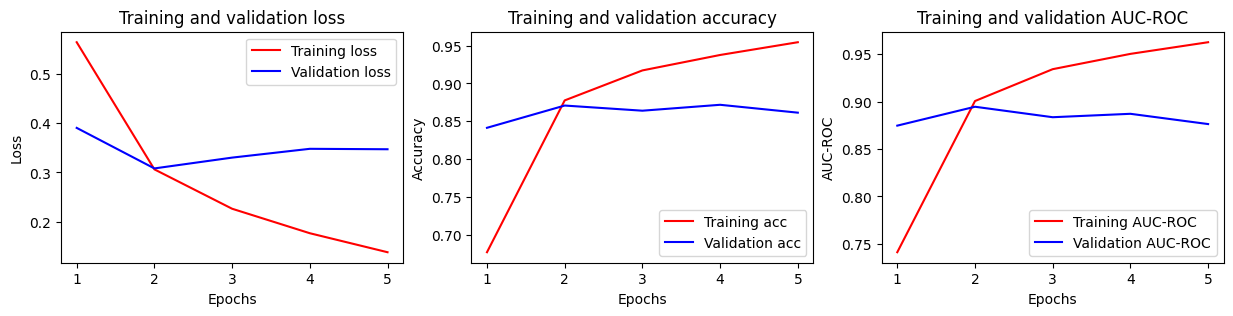

In [17]:
architectures = [
    tf.keras.layers.SimpleRNN,
    tf.keras.layers.LSTM,
    tf.keras.layers.GRU
]

hidden_layers_combinations = [
    [64, 16],
    [16, 64],
    [64],
]

dropouts = [0.2, 0.5]
l2_values = [0.01, 0.001]

completed_configs = set(
    (arch, hidden, dropout, l2)
    for arch, hidden, dropout, l2, *_ in precomputed_results
)
results = [
    (
        getattr(tf.keras.layers, arch),
        list(hidden),
        dropout,
        l2,
        acc,
        None,  # placeholder for history
        None   # placeholder for model
    )
    for arch, hidden, dropout, l2, acc, loss, auc in precomputed_results
]

param_grid = product(architectures, hidden_layers_combinations, dropouts, l2_values)
results = []

for architecture, hidden_layers, dropout, l2 in param_grid:
    config_key = (architecture.__name__, tuple(hidden_layers), dropout, l2)

    if config_key in completed_configs:
        print(f"⏭️ Skipping already computed: {config_key}")
        continue
    model, history, activations = build_and_train(architecture, hidden_layers, dropout, l2, verbose=1)

    test_loss, test_acc, test_auc = model.evaluate(test_ds, verbose=0)
    visulize_activations(architecture, activations)

    print(f"Architecture: {architecture}, Hidden layers: {hidden_layers}, "
    f"Dropout: {dropout}, L2: {l2}, Acc: {test_acc:.4f}, Loss: {test_loss:.4f}, "
    f"AUC: {test_auc:.4f}")
    results.append((architecture, hidden_layers, dropout, l2, test_acc, history, model))

    plot_history(history)

In [20]:
records = []
for arch, layers, dropout, l2, acc, *_ in results:
    records.append({
        "architecture": arch.__name__,
        "hidden_layers": str(layers),
        "dropout": dropout,
        "l2": l2,
        "accuracy": acc
    })

df = pd.DataFrame(records)

Dropout comparison

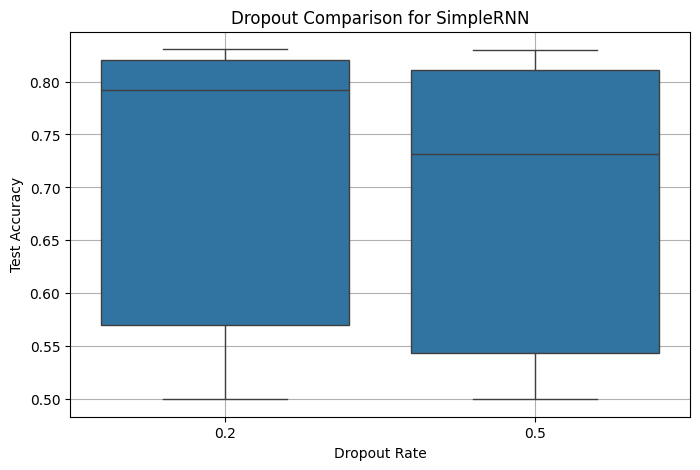

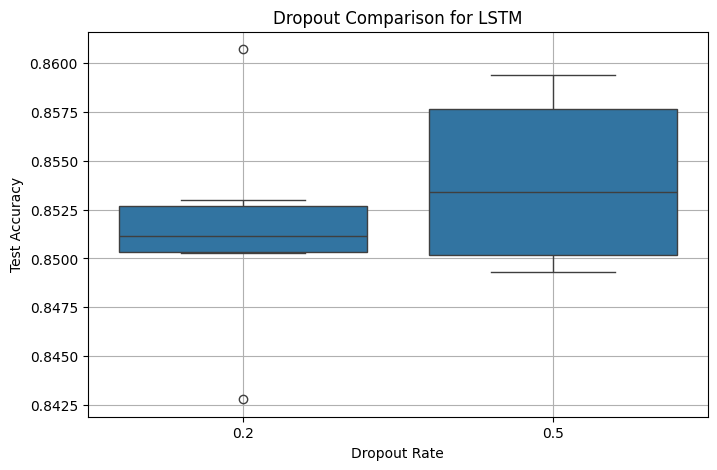

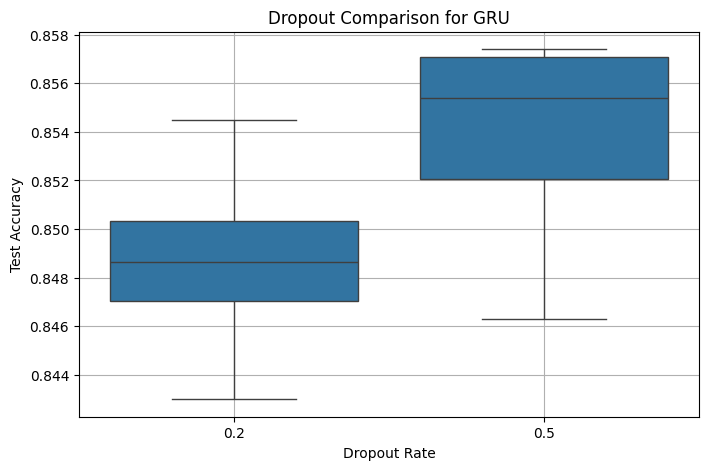

In [22]:
for arch_name in df["architecture"].unique():
    plt.figure(figsize=(8, 5))
    sns.boxplot(x="dropout", y="accuracy", data=df[df["architecture"] == arch_name])
    plt.title(f"Dropout Comparison for {arch_name}")
    plt.ylabel("Test Accuracy")
    plt.xlabel("Dropout Rate")
    plt.grid(True)
    plt.show()
    print('\n\n\n')

L2 comparisons

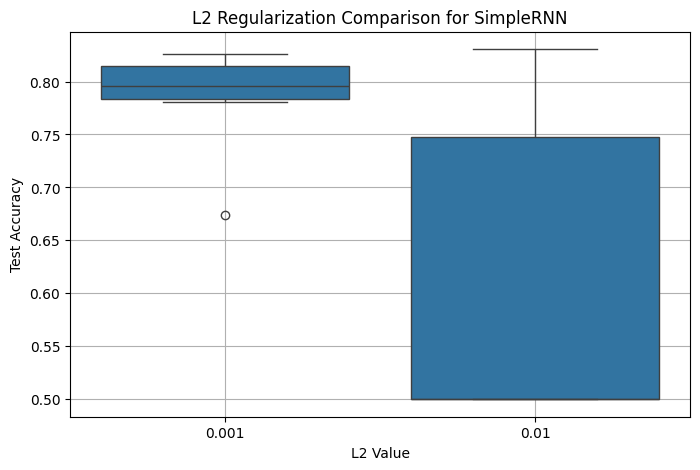

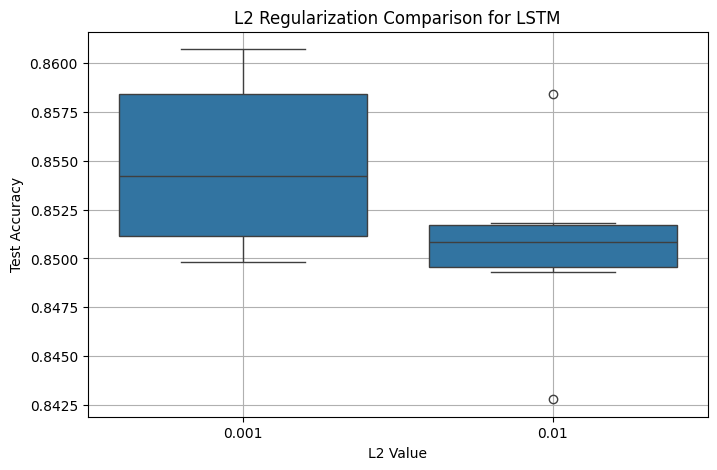

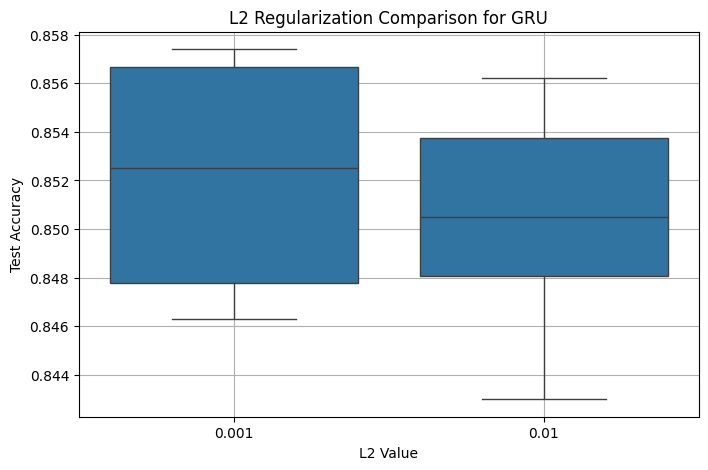

In [23]:
for arch_name in df["architecture"].unique():
    plt.figure(figsize=(8, 5))
    sns.boxplot(x="l2", y="accuracy", data=df[df["architecture"] == arch_name])
    plt.title(f"L2 Regularization Comparison for {arch_name}")
    plt.ylabel("Test Accuracy")
    plt.xlabel("L2 Value")
    plt.grid(True)
    plt.show()
    print('\n'*3)


Hidden layer comparisons

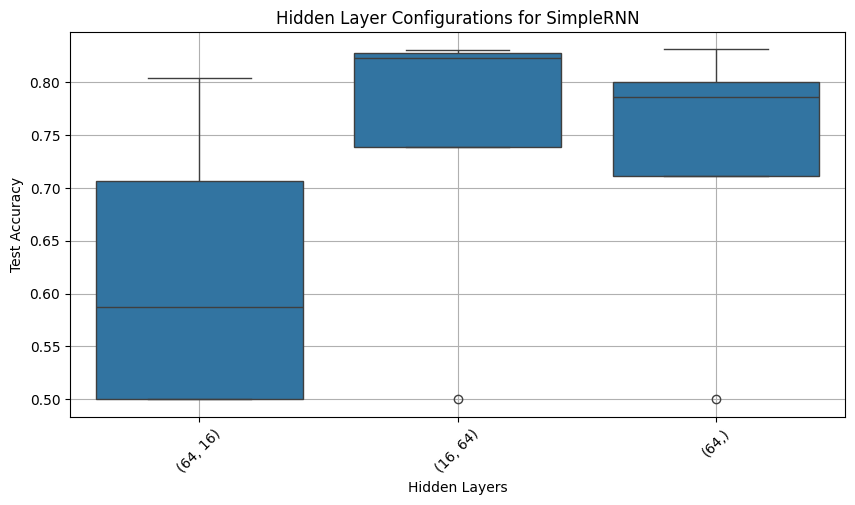

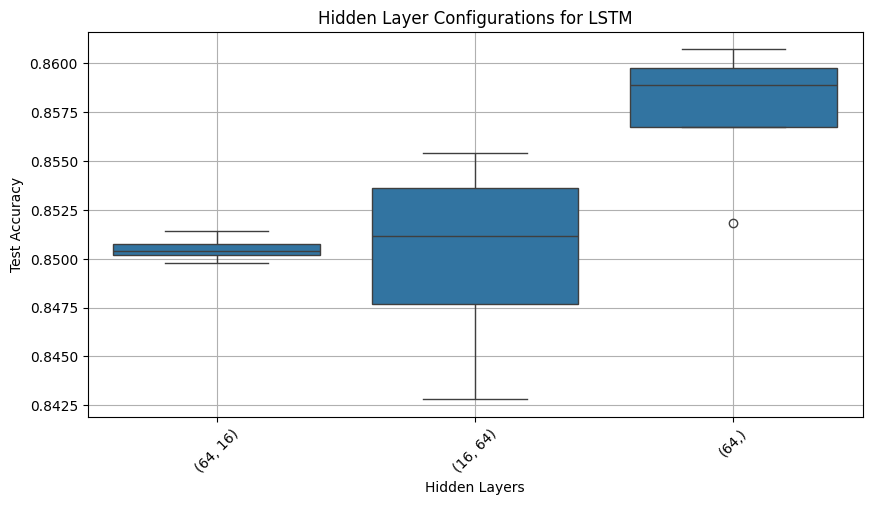

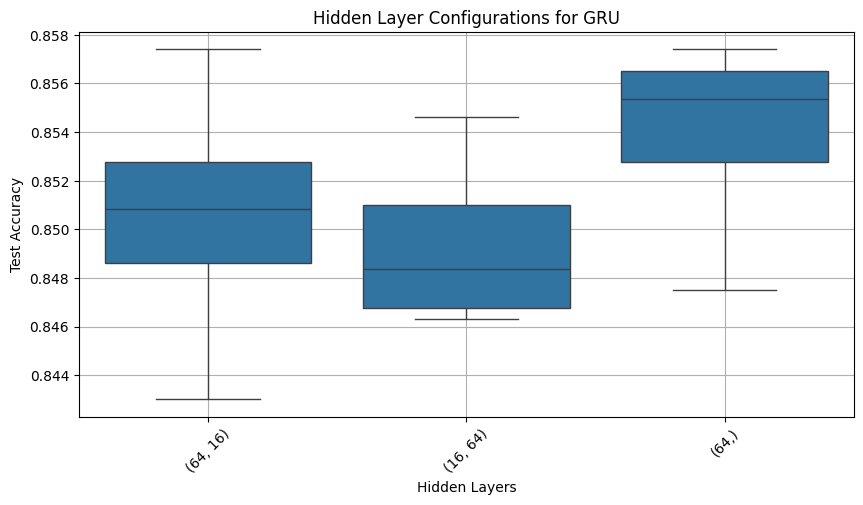

In [24]:
for arch_name in df["architecture"].unique():
    plt.figure(figsize=(10, 5))
    sns.boxplot(x="hidden_layers", y="accuracy", data=df[df["architecture"] == arch_name])
    plt.title(f"Hidden Layer Configurations for {arch_name}")
    plt.ylabel("Test Accuracy")
    plt.xlabel("Hidden Layers")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()
    print('\n'*3)
